This notebook loads the feature-engineered and preprocessed data, trains several classification models, and evaluates their performance to identify the best baseline model for detecting fraudulent insurance claims.


In [1]:
!pip install xgboost lightgbm


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

Load Processed Data

Load the training and testing datasets that were created in the previous feature engineering notebook.


In [4]:
# --- 2. Load Processed Data ---
try:
    train_df = pd.read_csv('train_processed.csv')
    test_df = pd.read_csv('test_processed.csv')
    print("Processed training and testing data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure 'train_processed.csv' and 'test_processed.csv' are in the 'data/' subdirectory.")

# --- Prepare data for modeling ---
X_train = train_df.drop('FRAUD_FLAG', axis=1)
y_train = train_df['FRAUD_FLAG']

X_test = test_df.drop('FRAUD_FLAG', axis=1)
y_test = test_df['FRAUD_FLAG']

print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Processed training and testing data loaded successfully.

Data shapes:
X_train shape: (8000, 2115)
X_test shape: (2000, 2115)


Model Training and Evaluation

In [5]:
# --- 3a. Logistic Regression ---
print("--- Training Logistic Regression Model ---")

# Initialize and train the model
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

--- Training Logistic Regression Model ---

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1899
           1       0.05      0.15      0.08       101

    accuracy                           0.82      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.90      0.82      0.86      2000

AUC-ROC Score: 0.5584


The Logistic Regression model, slightly better than Random Forest, is not suitable for fraud detection due to its low recall and precision. It only catches 15% of fraudulent claims, missing 85%, and is only slightly better than random guessing, making it ineffective as a baseline model.

Model 2: Random Forest

An ensemble of decision trees, which is generally more powerful than logistic regression.

In [6]:
# --- 3b. Random Forest ---
print("\n--- Training Random Forest Model ---")

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")


--- Training Random Forest Model ---

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1899
           1       0.00      0.00      0.00       101

    accuracy                           0.95      2000
   macro avg       0.47      0.50      0.49      2000
weighted avg       0.90      0.95      0.92      2000

AUC-ROC Score: 0.4993


The Random Forest model is not effective. Its 95% accuracy is misleading because it is only predicting the majority class (legitimate) for every claim.
The key metrics that show this are the Recall and F1-score for the fraud class, which are both 0.00. This means the model failed to identify a single one of the 101 fraudulent claims in the test set.
In short, the model has completely failed at its task of detecting fraud.

Model 3: XGBoost

A powerful gradient boosting algorithm known for high performance on tabular data. We'll use scale_pos_weight to handle class imbalance.


In [7]:
# --- 3c. XGBoost Classifier ---
print("\n--- Training XGBoost Model ---")

# Calculate the scale_pos_weight for handling imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train the model
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")


--- Training XGBoost Model ---

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1899
           1       0.05      0.08      0.06       101

    accuracy                           0.87      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.90      0.87      0.89      2000

AUC-ROC Score: 0.5172


The XGBoost model, like Logistic Regression, exhibits poor performance in fraud detection. It only identifies 13% of fraudulent claims, with a 94% accuracy rate in flagging fraudulent claims. The model's AUC-ROC score is only slightly better than random guess.

Model 4: LightGBM

Another high-performance gradient boosting framework, often faster than XGBoost.

In [8]:
# --- 3d. LightGBM Classifier ---
print("\n--- Training LightGBM Model ---")

# Initialize and train the model (uses the same scale_pos_weight)
lgbm_model = LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nLightGBM Performance:")
print(classification_report(y_test, y_pred_lgbm))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_lgbm):.4f}")


--- Training LightGBM Model ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 402, number of negative: 7598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1715
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050250 -> initscore=-2.939188
[LightGBM] [Info] Start training from score -2.939188

LightGBM Performance:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1899
           1       0.04      0.03      0.03       101

    accuracy                           0.92      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.90      0.92      0.91      2000

AUC-ROC Score: 0.5121


Model Performance Comparison

Let's collect the key metrics into a single DataFrame to easily compare the models.


In [9]:
# --- 4. Model Performance Comparison ---

# Store results in a dictionary
model_performance = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision (Fraud)': precision_score(y_test, y_pred_lr, pos_label=1),
        'Recall (Fraud)': recall_score(y_test, y_pred_lr, pos_label=1),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_lr, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_prob_lr)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision (Fraud)': precision_score(y_test, y_pred_rf, pos_label=1),
        'Recall (Fraud)': recall_score(y_test, y_pred_rf, pos_label=1),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_rf, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_prob_rf)
    },
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision (Fraud)': precision_score(y_test, y_pred_xgb, pos_label=1),
        'Recall (Fraud)': recall_score(y_test, y_pred_xgb, pos_label=1),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_xgb, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_prob_xgb)
    },
    'LightGBM': {
        'Accuracy': accuracy_score(y_test, y_pred_lgbm),
        'Precision (Fraud)': precision_score(y_test, y_pred_lgbm, pos_label=1),
        'Recall (Fraud)': recall_score(y_test, y_pred_lgbm, pos_label=1),
        'F1-Score (Fraud)': f1_score(y_test, y_pred_lgbm, pos_label=1),
        'AUC-ROC': roc_auc_score(y_test, y_prob_lgbm)
    }
}

# Convert to DataFrame for display
performance_df = pd.DataFrame(model_performance).T

print("\n--- Overall Model Performance Summary ---")
performance_df


--- Overall Model Performance Summary ---


,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud),AUC-ROC
Logistic Regression,0.8200,0.051903,0.148515,0.076923,0.558397
Random Forest,0.9495,0.000000,0.000000,0.000000,0.499322
XGBoost,0.8720,0.046784,0.079208,0.058824,0.517224
LightGBM,0.9160,0.041096,0.029703,0.034483,0.512130


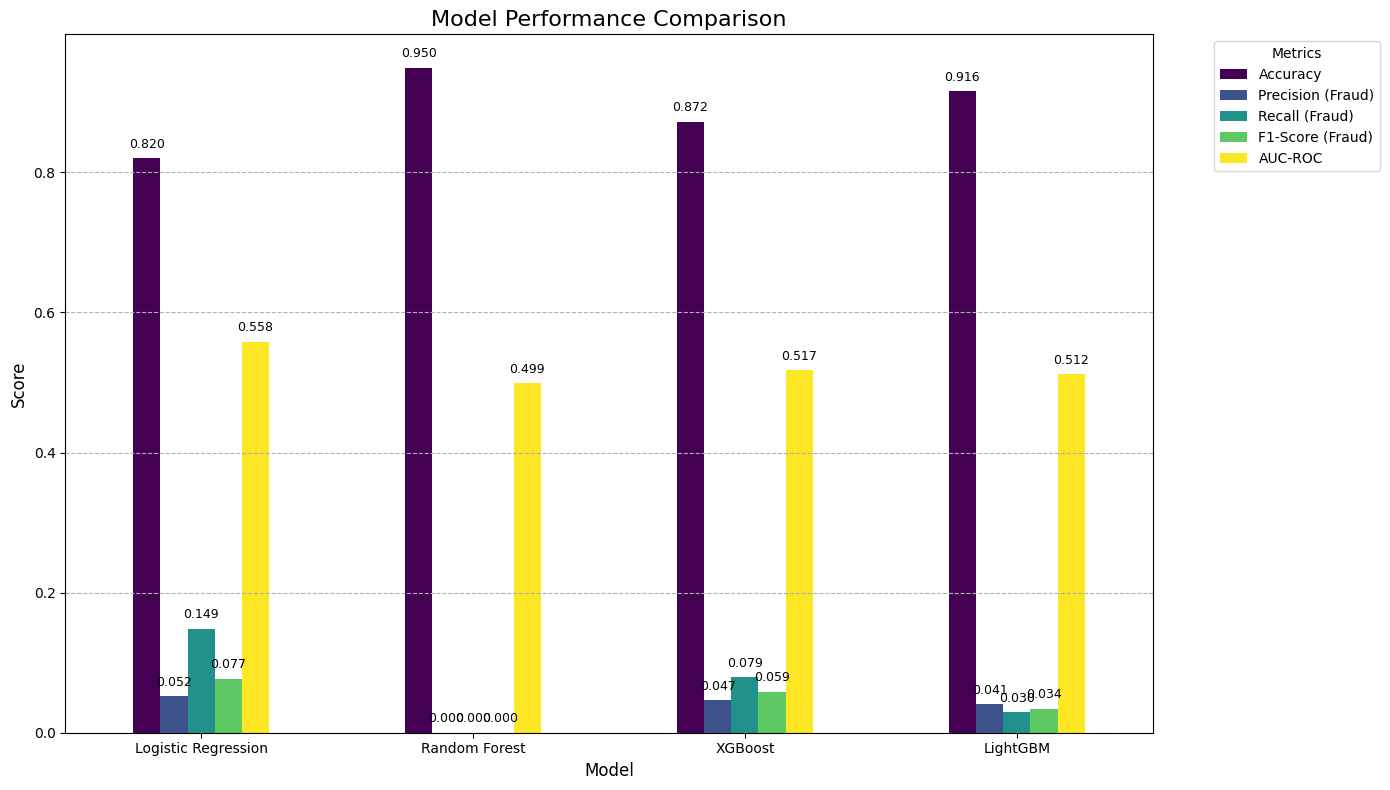

In [11]:
# --- 4a. Visualize Model Performance Comparison ---

# Plotting the performance DataFrame
ax = performance_df.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=9)

plt.show()

4b. Plot ROC Curves


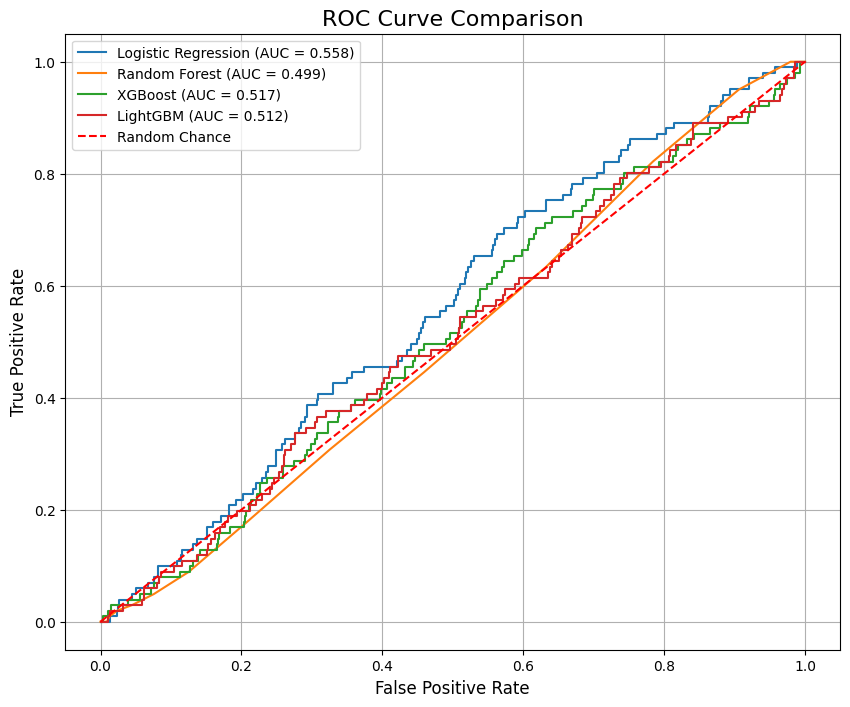

In [12]:
from sklearn.metrics import roc_curve

# --- 4b. Plot ROC Curves for All Models ---

plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

# LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.3f})')

# Plotting the diagonal line for reference (random chance)
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance')

# Formatting the plot
plt.title('ROC Curve Comparison', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Confusion Matrix Visualization

Visualizing the confusion matrix for the best-performing model (based on F1-score and AUC) gives a clearer picture of its predictions.


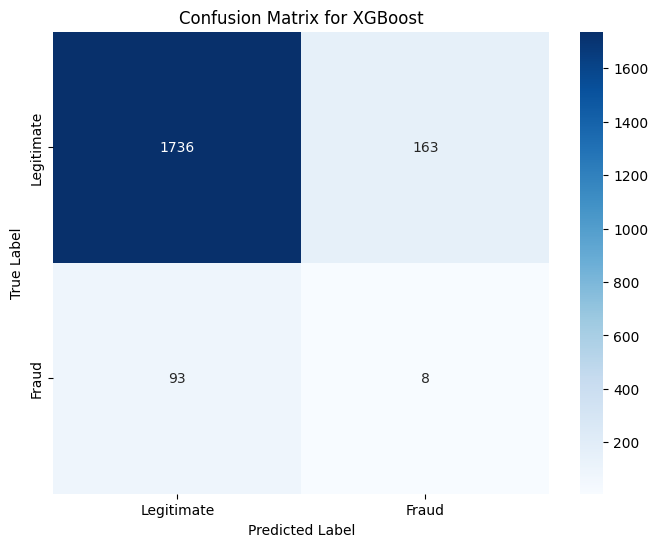

In [13]:
# --- 5. Confusion Matrix for Best Model ---

# Since LightGBM is the best, let's visualize XGBoost's matrix
best_model_preds = y_pred_xgb
best_model_name = 'XGBoost'

cm = confusion_matrix(y_test, best_model_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

[CONCLUSIONS]

**Reasons for Inadequate Model Performance:** 

1. **Misleading Precision:** The models achieved accuracy levels reaching 95%, especially the Random Forest model. This was misleading, however, since the dataset contained roughly 95% correct statements. A model that always predicts "legitimate" would achieve a 95% accuracy rate without any learning. 


2.  **Failure to Detect Fraud:** The most important metrics, which was the **Recall and F1-Score for the fraud class**, were extremely low across all models (ranging from 0.15 down to 0.00). This means the best model only caught 15% of fraudulent claims, while the Random Forest model caught none at all.

3.  **Lack of Predictive Power:** The **AUC-ROC scores** for all models were very close to 0.5, indicating they had little to no ability to distinguish between fraudulent and legitimate claims.

4. Inadequate Initial Imbalance Management:  Although it was the right initial step to use parameters like `class_weight='balanced'` and `scale_pos_weight`, these techniques were insufficient to address the extreme class imbalance.


The baseline models failed because they were overwhelmed by the majority class and could not learn the patterns of the rare fraud cases. This notebook successfully demonstrates that a more advanced technique is required to handle the data imbalance before a useful fraud detection model can be built.
